<a href="https://colab.research.google.com/github/vedpd/Maersk_Assignment/blob/main/Vessel_Maersk_full_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Library imports

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
# color_pal = sns.color_palette()
# plt.style.use('fivethirtyeight')

# 2.Base util functions

## 1.Inspecting data details for a dataframe

In [2]:
# Information of variables for data set:
def inspect_data(data):
    data_details =  pd.DataFrame({"Data Type":data.dtypes,
                         "Count of Blank Values":data.apply(lambda x: x.isin([' ']).sum(),axis=0),
                        "Count of Missing Values":data.apply(lambda x: x.isnull().sum(),axis=0),
                         "% of Missing Values":data.apply(lambda x: round(x.isnull().sum()/len(x.index)*100,2),axis=0),
                        "No of Unique Data":data.apply(lambda x: x.nunique(),axis=0),
                         "Levels":data.apply(lambda x: str(x.unique()),axis=0)
                        })
    return data_details#### 2. Finding numeric and categorical column details

## 2.Finding numeric and categorical column details

In [3]:
def col_type(df):
    category='object'
    catcols=df.select_dtypes(include=category).columns
    numcols=df.select_dtypes(exclude=category).columns
    return catcols,numcols

##################################################
# Example :-
#cat_cols=col_type(df)[0]
#num_cols=col_type(df)[1]
#cat_cols
#num_cols

## 3.Generating catplot with 1 categorical variable and 1 target categorical variable for entire dataframe

In [4]:
def catcol_plot(df,target):
    cols=col_type(df)
    cat_cols=cols[0].tolist()  # change
    colrefs=cat_cols.copy()    #list(df[cat_cols].columns)
    colrefs.remove(target)   #remove categorical target vairable
    #remove customerid/index details
    colrefs=colrefs[1:]
    for col in colrefs:
        #print(col)
        plt.figure(figsize = (8,6))
        plt.subplot(1,1,1)
        sns.countplot(x=col,data=df,hue=target).set_title(col + " vs" + target)


#######################################################
## Example for function call
## catcol_plot(tel,'Churn')
## Churn is your target variable
## tel is your dataframe details

## 4.Generating scatterplot with 1 numerical variable and 1 target numerical variable for entire dataframe

In [5]:
def numcol_plot(df,target):
    cols=col_type(df)
    num_cols=cols[1]
    colrefs=list(df[num_cols].columns)
    colrefs.remove(target)
    #remove customerid/index details
    colrefs=colrefs[1:]
    for col in colrefs:
        #print(col)
        plt.figure(figsize = (8,6))
        plt.subplot(1,1,1)
        sns.scatterplot(x=col,data=df,y=target).set_title(col + " vs " + target)
        plt.legend(loc='upper center', bbox_to_anchor=(1, 0.8))
        plt.xticks(rotation=65, horizontalalignment='right',fontweight='light')

## 5.Generating bar chart for categorical columns vs numerical target

In [6]:
def barCat_plot(df,target):
    cols=col_type(df)
    cat_cols=cols[0]
    colrefs=list(df[cat_cols].columns)
    #colrefs.remove(target)
    #remove customerid/index details
    #colrefs=colrefs[1:]
    for col in colrefs:
        #print(col)
        plt.figure(figsize = (8,6))
        plt.subplot(1,1,1)
        sns.barplot(x=col,data=df,y=target).set_title(col + " vs " + target)
        plt.legend(loc='upper center', bbox_to_anchor=(1, 0.8))
        plt.xticks(rotation=65, horizontalalignment='right',fontweight='light')

# 3.Reading the data

In [58]:
vessel_df = pd.read_csv("Vessel journey data.csv")

In [59]:
vessel_df.shape, vessel_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1985 entries, ('5ecc997b4ba2be0c8cd60cfa6548e72a92db0e48', '2023-07-01', '2023-07-01', '2023-07-01T13:01:32.000Z', '2023-07-01T23:01:33.000Z', 9329631, 'NORTHERN DEDICATION', 'Container Ship', 'United Arab Emirates', 'AE', 'Abu Dhabi', 'KPCT-2 -COSCO(Khalifa Port Container Terminal)', 10.000277777777775, 'CMA - INDKHIQ | SFN - UIG', 230.98, '2023-06-30T11:01:06.000Z', 3400, 'Jebel Ali', '2023-06-26T10:04:04.000Z', 96.95055555555555, 26.00722222222222, 46.43239390268057, 20.0, '0f97208f6febb7af19d168321e2aea6de9e0c963', 'Umm Qasr', '2023-07-06T00:00:45.000Z', 54.00416666666667, 96.98666666666666, 503.68224129407145, 51.0) to ('bec58affdb0719c13001b66430cc05d2fa5d44b6', '2022-06-15', '2022-06-15', '2022-06-15T07:04:07.000Z', '2022-06-15T23:26:24.000Z', 9347803, 'ANNE', 'Container Ship', 'Algeria', 'DZ', 'Bejaia', 'Bejaia Mediterranean Terminal', 16.371388888888887, 'MSC - ANNABA', 139.14, '2022-06-14T01:42:04.000Z', 957, 'Bejaia', '2022-0

((1985, 1), None)

## 3.1:Relation Between call ids

In [9]:
vessel_df["prev_call_id"].nunique(), vessel_df["call_id"].nunique(), vessel_df["next_call_id"].nunique()

(68580, 68909, 67883)

1. Clearly we see that call id is having similar counts in case of previous, current and next
2. As a next step, lets look at if previous call id is sitting in current call id and similarly if next call id is sitting as current call id or not

In [10]:
vessel_df["call_id"].isin(vessel_df["next_call_id"]).sum(), vessel_df["call_id"].isin(vessel_df["prev_call_id"]).sum(),((vessel_df["call_id"].isin(vessel_df["next_call_id"])) & (vessel_df["call_id"].isin(vessel_df["prev_call_id"]))).sum()

(66781, 66780, 64886)

In [11]:
9093/9882

0.9201578627808136

 We can see almost 9093 of the current call id has information of previous and next call id, which means we can only concentrate on current call id to do our analysis using this data


** Assumption : ** </br>
Since more than 90% of current call id has previous as well as next call id information, we can consider all the rows of current call id only

## 3.2: Basic summary statistics

In [12]:
vessel_df.describe(include="all").T

count unique  \
call_id                      68927  68909   
arrival_date                 68927    730   
departure_date               68927    743   
arrival_time                 68927  67898   
departure_time               68927  68256   
imo                        68927.0    NaN   
vessel_name_ais              68927   2416   
vessel_type_ais              68905      9   
Country                      68927    113   
CountryCode                  68811    111   
Port                         68927    364   
Terminal                     68927    761   
Duration                   68927.0    NaN   
Service_name                 68927    823   
length                     68671.0    NaN   
prev_departure_time          68678  67403   
vesteu                     68927.0    NaN   
prev_port                    68598    364   
prev_arrival_time            68598  67624   
prev_duration              68598.0    NaN   
prev_leg_duration          68678.0    NaN   
prev_leg_distance_nm       68671.0    NaN   
prev_leg_stationary_hours  68927.0    NaN   
prev_call_id                 68598  68580   
next_port                    67901    364   
next_arrival_time            67901  66928   
next_duration              67901.0    NaN   
next_leg_duration          67900.0    NaN   
next_leg_distance_nm       67891.0    NaN   
next_leg_stationary_hours  67900.0    NaN   
next_call_id                 67900  67883   

                                                                top   freq  \
call_id                    6ae58fe2617c5378337ed4e44ffcac38f12c91ba      2   
arrival_date                                             2023-01-20    139   
departure_date                                           2023-05-24    131   
arrival_time                               2023-01-21T08:01:38.000Z      3   
departure_time                             2023-03-27T19:00:11.000Z      3   
imo                                                             NaN    NaN   
vessel_name_ais                                                 JAN    583   
vessel_type_ais                                      Container Ship  43486   
Country                                                       China   8492   
CountryCode                                                      CN   8492   
Port                                                      Singapore   3026   
Terminal                                     Pasir Panjang Terminal   2344   
Duration                                                        NaN    NaN   
Service_name                                                Unknown  24108   
length                                                          NaN    NaN   
prev_departure_time                        2023-01-24T16:00:04.000Z      3   
vesteu                                                          NaN    NaN   
prev_port                                                 Singapore   3013   
prev_arrival_time                          2023-07-22T15:00:10.000Z      3   
prev_duration                                                   NaN    NaN   
prev_leg_duration                                               NaN    NaN   
prev_leg_distance_nm                                            NaN    NaN   
prev_leg_stationary_hours                                       NaN    NaN   
prev_call_id               dcf97e6eac8ad3acaeffba5a24e4555392d12719      2   
next_port                                                 Singapore   3028   
next_arrival_time                          2023-04-28T10:00:00.000Z      3   
next_duration                                                   NaN    NaN   
next_leg_duration                                               NaN    NaN   
next_leg_distance_nm                                            NaN    NaN   
next_leg_stationary_hours                                       NaN    NaN   
next_call_id               1ddaa9973a7331b1a5449f7da56d931f1a0aa487      2   

                                     mean            std         min  \
call_id            

In [13]:
inspect_data(vessel_df)

Data Type  Count of Blank Values  \
call_id                      object                      0   
arrival_date                 object                      0   
departure_date               object                      0   
arrival_time                 object                      0   
departure_time               object                      0   
imo                           int64                      0   
vessel_name_ais              object                      0   
vessel_type_ais              object                      0   
Country                      object                      0   
CountryCode                  object                      0   
Port                         object                      0   
Terminal                     object                      0   
Duration                    float64                      0   
Service_name                 object                      0   
length                      float64                      0   
prev_departure_time          object                      0   
vesteu                        int64                      0   
prev_port                    object                      0   
prev_arrival_time            object                      0   
prev_duration               float64                      0   
prev_leg_duration           float64                      0   
prev_leg_distance_nm        float64                      0   
prev_leg_stationary_hours     int64                      0   
prev_call_id                 object                      0   
next_port                    object                      0   
next_arrival_time            object                      0   
next_duration               float64                      0   
next_leg_duration           float64                      0   
next_leg_distance_nm        float64                      0   
next_leg_stationary_hours   float64                      0   
next_call_id                 object                      0   

                           Count of Missing Values  % of Missing Values  \
call_id                                          0                 0.00   
arrival_date                                     0                 0.00   
departure_date                                   0                 0.00   
arrival_time                                     0                 0.00   
departure_time                                   0                 0.00   
imo                                              0                 0.00   
vessel_name_ais                                  0                 0.00   
vessel_type_ais                                 22                 0.03   
Country                                          0                 0.00   
CountryCode                                    116                 0.17   
Port                                             0                 0.00   
Terminal                                         0                 0.00   
Duration                                         0                 0.00   
Service_name                                     0                 0.00   
length                                         256                 0.37   
prev_departure_time                            249                 0.36   
vesteu                                           0                 0.00   
prev_port                                      329                 0.48   
prev_arrival_time                              329                 0.48   
prev_duration                                  329                 0.48   
prev_leg_duration                              249                 0.36   
prev_leg_distance_nm                           256                 0.37   
prev_leg_stationary_hours                        0                 0.00   
prev_call_id                                   329                 0.48   
next_port                                     1026                 1.49   
next_arrival_time                             1026                 1.49   
next_duration   

# 4:Creating Time related features

In [14]:
vessel_df['arrival_date']= pd.to_datetime(vessel_df['arrival_date'])
vessel_df['arrival_time']= pd.to_datetime(vessel_df['arrival_time'])
vessel_df['departure_date']= pd.to_datetime(vessel_df['departure_date'])
vessel_df['departure_time']= pd.to_datetime(vessel_df['departure_time'])

In [15]:
def custom_time_features(df):
  df['arrival_month']= df['arrival_date'].dt.month
  df['departure_month']= df['departure_date'].dt.month

  df["arrival_year"]= df['arrival_date'].dt.year
  df["departure_year"]= df['departure_date'].dt.year

  df["dayoftheweek_arrival"]= df['arrival_date'].dt.dayofweek
  df["dayoftheweek_departure"]= df['departure_date'].dt.dayofweek


  df["dayofthemonth_arrival"]= df['arrival_date'].dt.day
  df["dayofthemonth_departure"]= df['departure_date'].dt.day


  df["houroftheday_arrival"]= df['arrival_time'].dt.hour
  df["houroftheday_departure"]= df['departure_time'].dt.hour

  df['weekoftheyear_arrival']= df['arrival_date'].dt.week

  df['quarter_of_year_arrival'] = df['arrival_month'].apply(lambda x: 1 if x <= 3 else (2 if x <= 6 else (3 if x <= 9 else 4)))

  return df

# New Section

In [16]:
vessel_df = custom_time_features(vessel_df)

vessel_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68927 entries, 0 to 68926
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   call_id                    68927 non-null  object             
 1   arrival_date               68927 non-null  datetime64[ns]     
 2   departure_date             68927 non-null  datetime64[ns]     
 3   arrival_time               68927 non-null  datetime64[ns, UTC]
 4   departure_time             68927 non-null  datetime64[ns, UTC]
 5   imo                        68927 non-null  int64              
 6   vessel_name_ais            68927 non-null  object             
 7   vessel_type_ais            68905 non-null  object             
 8   Country                    68927 non-null  object             
 9   CountryCode                68811 non-null  object             
 10  Port                       68927 non-null  object             
 11  Te

<ipython-input-15-3fd38f929f23>:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekoftheyear_arrival']= df['arrival_date'].dt.week


# 5.EDA: Univariate, Bivariate

In [17]:
#Sort the data based on arrival date so that we can see some patterns
vessel_df =vessel_df.sort_values(by="arrival_date")

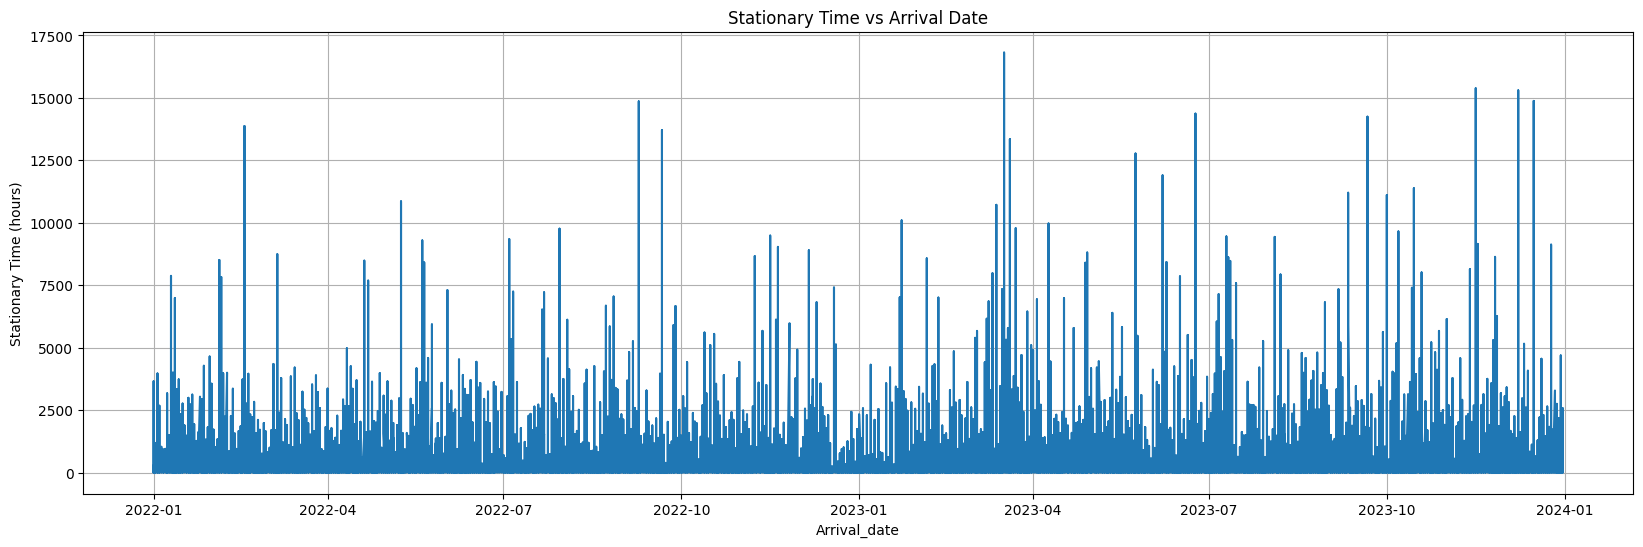

In [18]:
plt.figure(figsize=(20, 6))
plt.plot(vessel_df['arrival_date'], vessel_df['prev_leg_stationary_hours'])
plt.xlabel('Arrival_date')
plt.ylabel('Stationary Time (hours)')
plt.title('Stationary Time vs Arrival Date')
plt.grid(True)
plt.show()

Above data does show some pattern but it isn't very clear as there are spikes which might be noise in this case happening across different ports

In [19]:
ports = vessel_df['Port'].unique()

len(ports)

364

## 5.2:Interactive Port level stationary hours distribution

Since there are too many ports it would be difficult to visualize each of these ports



In [20]:
import plotly.graph_objects as go
import plotly.express as px

# Create a figure
fig = go.Figure()

for port in vessel_df['Port'].unique():
    port_data = vessel_df[vessel_df['Port'] == port]
    fig.add_trace(go.Scatter(x=port_data['arrival_date'], y=port_data['prev_leg_stationary_hours'], mode='lines', name=port))

# Update layout
fig.update_layout(title='Stationary Time over Time for Different Ports',
                  xaxis_title='Arrival Date',
                  yaxis_title='Stationary Time (hours)',
                  xaxis=dict(rangeslider=dict(visible=True)),
                  )

# Show plot
fig.show()

In [21]:
import pandas as pd
import plotly.express as px

# Create a line chart with dropdown menu for ports
fig = px.line(vessel_df, x='arrival_date', y='prev_leg_stationary_hours', color='Port',
              title='Stationary Time over Time for Different Ports',
              labels={'arrival_date': 'Arrival Date', 'prev_leg_stationary_hours': 'Stationary Time (hours)'},
              )
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()


### Bubble chart to look at average stationary hours for each port

In [43]:
vessel_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68927 entries, 7783 to 30272
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   call_id                    68927 non-null  object             
 1   arrival_date               68927 non-null  datetime64[ns]     
 2   departure_date             68927 non-null  datetime64[ns]     
 3   arrival_time               68927 non-null  datetime64[ns, UTC]
 4   departure_time             68927 non-null  datetime64[ns, UTC]
 5   imo                        68927 non-null  int64              
 6   vessel_name_ais            68927 non-null  object             
 7   vessel_type_ais            68905 non-null  object             
 8   Country                    68927 non-null  object             
 9   CountryCode                68811 non-null  object             
 10  Port                       68927 non-null  object             
 11 

In [45]:
#create a bubble chart for average stationary hours for different ports using vessel_df
average_stationary_hours = vessel_df.groupby('Port')['prev_leg_stationary_hours'].mean().reset_index()

# Create interactive bubble chart using Plotly
fig = px.scatter(average_stationary_hours, x='Port', y='prev_leg_stationary_hours', size='prev_leg_stationary_hours',
                  hover_name='Port', title='Average Stationary Hours for Different Ports',
                  labels={'Port': 'Port', 'prev_leg_stationary_hours': 'Average Stationary Hours'})

# Update layout for better readability
fig.update_layout(xaxis=dict(title='Port'), yaxis=dict(title='Average Stationary Hours'), xaxis_tickangle=-45, showlegend=False)

fig.show()

1. Note: It would be interesting to map the port to the country as well as to the continent and then map the average stationary hours

### Bubble charts at a country level

In [46]:
average_stationary_hours = vessel_df.groupby('Country')['prev_leg_stationary_hours'].mean().reset_index()

# Create interactive bubble chart using Plotly
fig = px.scatter(average_stationary_hours, x='Country', y='prev_leg_stationary_hours', size='prev_leg_stationary_hours',
                  hover_name='Country', title='Average Stationary Hours for Different Countries',
                  labels={'Country': 'Country', 'prev_leg_stationary_hours': 'Average Stationary Hours'})

# Update layout for better readability
fig.update_layout(xaxis=dict(title='Country'), yaxis=dict(title='Average Stationary Hours'), xaxis_tickangle=-45, showlegend=False)

fig.show()

 We can even convert this to a country level data and see which country is having majority of stationary hours and then drill down to see which months face maximum stationary hours : this information will get baked into the data using the time based variables: month of the year, and also using the country (which can be encoded) to come up with a country level information

# 6: Baseline Xgboost model

In [22]:
vessel_df['arrival_date'].min(), vessel_df['arrival_date'].max()

(Timestamp('2022-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00'))

In [23]:
import sklearn
import pandas as pd
import numpy as np
import gc
from xgboost.sklearn import XGBRegressor

## Train test split

In [24]:
train = vessel_df.loc[vessel_df.arrival_date < '2023-06-01']
test = vessel_df.loc[(vessel_df.arrival_date >= '2023-06-01') & (vessel_df.arrival_date < '2023-09-01')]
val = vessel_df.loc[vessel_df.arrival_date >= '2023-09-01']



In [25]:
train.shape, test.shape,val.shape

((47030, 43), (9551, 43), (12346, 43))

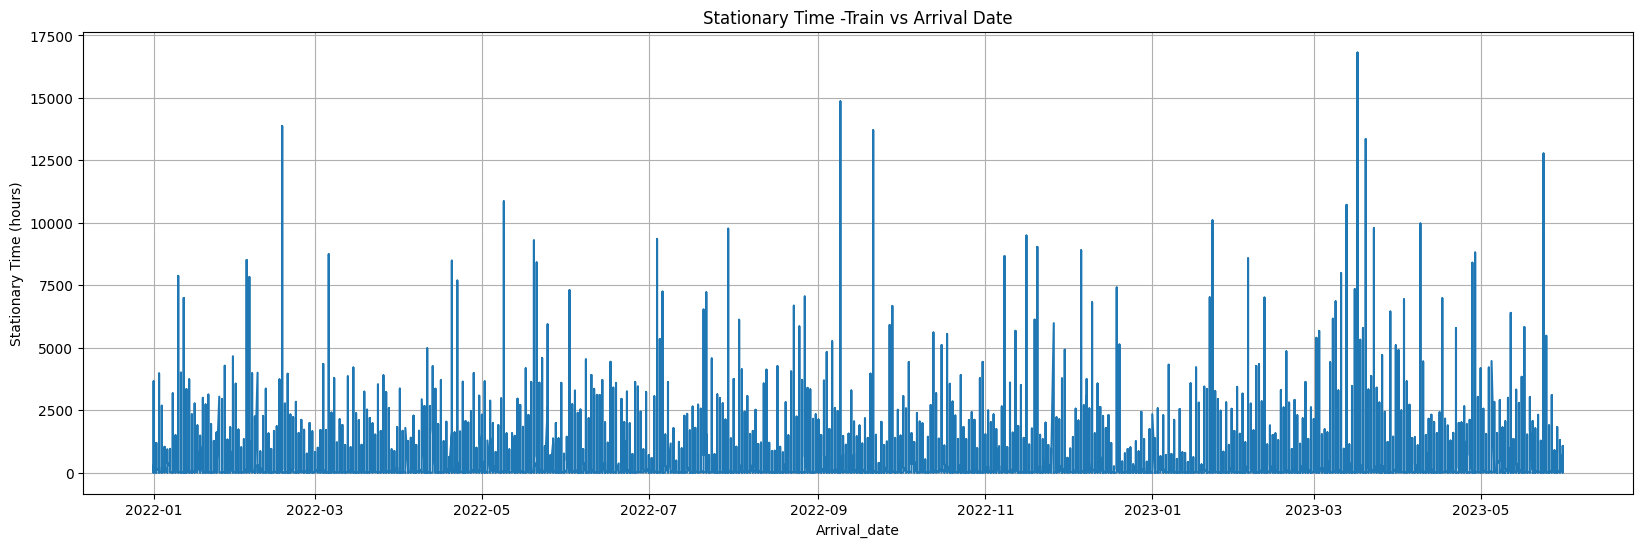

In [26]:
plt.figure(figsize=(20, 6))
plt.plot(train['arrival_date'], train['prev_leg_stationary_hours'])
plt.xlabel('Arrival_date')
plt.ylabel('Stationary Time (hours)')
plt.title('Stationary Time -Train vs Arrival Date')
plt.grid(True)
plt.show()

In [27]:
import pandas as pd
import plotly.express as px

# Assuming you have separate DataFrames named 'train_df', 'test_df', and 'val_df'
# with columns 'arrival_date' and 'prev_leg_stationary_hours'

# Create a DataFrame to combine train, test, and val datasets
combined_df = pd.concat([train, test, val])

# Define color mapping for each dataset
color_mapping = {'train': 'blue', 'test': 'green', 'val': 'red'}

# Create a line chart with separate lines for train, test, and val datasets
fig = px.line(combined_df, x='arrival_date', y='prev_leg_stationary_hours', color='dataset',
              title='Stationary Time vs Arrival Date for Train, Test, and Validation Datasets',
              labels={'arrival_date': 'Arrival Date', 'prev_leg_stationary_hours': 'Stationary Time (hours)'},
              color_discrete_map=color_mapping)
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()


ValueError: Value of 'color' is not the name of a column in 'data_frame'. Expected one of ['call_id', 'arrival_date', 'departure_date', 'arrival_time', 'departure_time', 'imo', 'vessel_name_ais', 'vessel_type_ais', 'Country', 'CountryCode', 'Port', 'Terminal', 'Duration', 'Service_name', 'length', 'prev_departure_time', 'vesteu', 'prev_port', 'prev_arrival_time', 'prev_duration', 'prev_leg_duration', 'prev_leg_distance_nm', 'prev_leg_stationary_hours', 'prev_call_id', 'next_port', 'next_arrival_time', 'next_duration', 'next_leg_duration', 'next_leg_distance_nm', 'next_leg_stationary_hours', 'next_call_id', 'arrival_month', 'departure_month', 'arrival_year', 'departure_year', 'dayoftheweek_arrival', 'dayoftheweek_departure', 'dayofthemonth_arrival', 'dayofthemonth_departure', 'houroftheday_arrival', 'houroftheday_departure', 'weekoftheyear_arrival', 'quarter_of_year_arrival'] but received: dataset

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47030 entries, 7783 to 46482
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   call_id                    47030 non-null  object             
 1   arrival_date               47030 non-null  datetime64[ns]     
 2   departure_date             47030 non-null  datetime64[ns]     
 3   arrival_time               47030 non-null  datetime64[ns, UTC]
 4   departure_time             47030 non-null  datetime64[ns, UTC]
 5   imo                        47030 non-null  int64              
 6   vessel_name_ais            47030 non-null  object             
 7   vessel_type_ais            47010 non-null  object             
 8   Country                    47030 non-null  object             
 9   CountryCode                46943 non-null  object             
 10  Port                       47030 non-null  object             
 11 

## Model

In [29]:
FEATURES = ['arrival_month', 'departure_month', 'arrival_year', 'departure_year', 'dayoftheweek_arrival', 'dayoftheweek_departure',
       'dayofthemonth_arrival', 'dayofthemonth_departure',
       'houroftheday_arrival', 'houroftheday_departure',
       'weekoftheyear_arrival', 'quarter_of_year_arrival','length']
TARGET = 'prev_leg_stationary_hours'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [30]:
X_train.dtypes

arrival_month                int64
departure_month              int64
arrival_year                 int64
departure_year               int64
dayoftheweek_arrival         int64
dayoftheweek_departure       int64
dayofthemonth_arrival        int64
dayofthemonth_departure      int64
houroftheday_arrival         int64
houroftheday_departure       int64
weekoftheyear_arrival        int64
quarter_of_year_arrival      int64
length                     float64
dtype: object

In [31]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=200,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,gamma=30,
                       min_child_weight=1,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       learning_rate=0.1,eval_metric='rmse')
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:487.64292	validation_1-rmse:526.92160


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[15:20:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



[100]	validation_0-rmse:456.65902	validation_1-rmse:499.82668
[199]	validation_0-rmse:449.75843	validation_1-rmse:496.28830


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=30, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Testing for single port

In [32]:
[ x for x in ports if "New York" in x]

['New York']

In [33]:
train_NewYork = train[train['Port'] == 'New York']
test_NewYork = test[test['Port'] == 'New York']
val_NewYork = val[val['Port'] == 'New York']

In [34]:
X_train_ny = train_NewYork[FEATURES]
y_train_ny = train_NewYork[TARGET]

X_test_ny = test_NewYork[FEATURES]
y_test_ny = test_NewYork[TARGET]

In [35]:
reg_ny = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,gamma=30,
                       min_child_weight=1,
                       subsample=0.8,
                       colsample_bytree=0.8,
                       learning_rate=0.1,eval_metric='rmse')
reg_ny.fit(X_train_ny, y_train_ny,
        eval_set=[(X_train_ny, y_train_ny), (X_test_ny, y_test_ny)],
        verbose=100)

[0]	validation_0-rmse:74.75114	validation_1-rmse:11.65376
[87]	validation_0-rmse:2.92701	validation_1-rmse:4.89351


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning:

[15:20:11] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.



XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=30, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Label Encoding entire data

In [36]:
# lag features = lag by 7 days, lag by 14 days, lag by 21 days, lag by 28 days (weekly lag)
# build xgboost model using lag features
# use hyperopt to do model tuning
# for port : do target encoding or one hot encoding
# for vessel type : do one hot encoding

# use timeseries based models such as moving average, exponential smoothing
# try to find trend, seasonality in the data
# estimated arrival date  = actual arrival date - stationary hours(converted to day)

In [47]:
# validate if ports in train, test and val are same or not
train_ports = train['Port'].unique()
test_ports = test['Port'].unique()
val_ports = val['Port'].unique()


train_ports_set = set(train_ports)
test_ports_set = set(test_ports)
val_ports_set = set(val_ports)

train_ports_minus_test_ports = train_ports_set - test_ports_set
train_ports_minus_val_ports = train_ports_set - val_ports_set

In [48]:
len(train_ports_minus_test_ports),len(train_ports_minus_val_ports)

(19, 13)

In [49]:
train_ports_minus_test_ports

{'Calabar',
 'Copenhagen',
 'Degrad des cannes',
 'Durres',
 'Gulfport',
 'Jazan',
 'Kaliningrad',
 'Limon',
 'Lobito',
 'Nacala',
 'Ploce',
 'Shantou',
 'Takoradi',
 'Tartous',
 'Umm Al Quwain',
 'Wenzhou',
 'Zarate',
 'Zhangzhou',
 'huizhou'}

In [50]:
len([x for x in train_ports if x not in test_ports])

19

In [51]:
#only building the model for common ports between train, test, val: so that target encoding can be done in this case

train_test_val_ports = [x for x in train_ports if x in test_ports and x in val_ports]


train_port_df = train[train['Port'].isin(train_test_val_ports)]
test_port_df = test[test['Port'].isin(train_test_val_ports)]
val_port_df = val[val['Port'].isin(train_test_val_ports)]

In [52]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.8 MB/s eta 0:00:00


In [53]:
#Target encoding the ports
import category_encoders as ce

# Initialize TargetEncoder
encoder = ce.TargetEncoder(cols=['Port'])

# Fit the encoder on the training set
encoder.fit(train_port_df['Port'], train_port_df['prev_leg_stationary_hours'])

# Transform the categorical variable in train, test, and validation sets
train_port_df['Port_encoded'] = encoder.transform(train_port_df['Port'])
test_port_df['Port_encoded'] = encoder.transform(test_port_df['Port'])
val_port_df['Port_encoded'] = encoder.transform(val_port_df['Port'])


<ipython-input-53-a29d95f54fa0>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-53-a29d95f54fa0>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-53-a29d95f54fa0>:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
train_port_df.shape, test_port_df.shape, val_port_df.shape

((46835, 44), (9541, 44), (12308, 44))

In [55]:
train.shape, test.shape,val.shape

((47030, 43), (9551, 43), (12346, 43))